# Exploration 6. 수식 없이도 이해할 수 있는 ChatGPT와 Stable Diffusion

**학습내용**

- Generative AI(생성형 AI) 발전과정 이해
- ChatGPT를 사용해서 이미지 프롬프트 생성
- Stable Diffusion 모델로 이미지 생성

---

# Stable Diffusion 모델로 이미지 생성

[Hugging Face](https://huggingface.co/)를 이용

> 허깅페이스(Hugging Face)  
>  
> 트랜스포머(Transformer) 기반으로 하는 머신러닝 및 인공지능 모델과 데이터 셋을 제공하는 세계 최대 플랫폼이자 커뮤니티입니다. 모델을 사용하려면 직접 모델을 구현하고 훈련시켜 레이어와 모델을 선언해야 하지만 허깅페이스를 이용하면 간단한 코드만으로 모델을 사용할 수 있습니다. 뿐만 아니라 사용자들이 직접 구현한 모델이나 수집한 데이터셋을 공유하고 토론하는 커뮤니티 공간이 활발하게 운영되고 있습니다.


Stable Diffusion 모델 중 **[Diffuser](https://github.com/huggingface/diffusers)**사용

**Diffuser**
- 이미지, 오디오, 3D 분자구조 생성 모델
- 구성
    - 파이프라인(Autoencoder, Conditional Unet, Clip text encoder 등)
    - 스케줄러(속도와 결과물 품질 조정)
    - 사전학습된 모델 
    
[REF] [Hugging Face - stable diffusion pipelines](https://huggingface.co/docs/diffusers/v0.17.1/en/api/pipelines/stable_diffusion/overview)

# 모델 준비
- Diffusers 설치

In [1]:
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

# Text-to-Image Generation

In [2]:
# load Text-to-Image Generation pipeline
import torch
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler

device = 'cuda'

# make pipeline
repo_id = "stabilityai/stable-diffusion-2-base"
pipe = DiffusionPipeline.from_pretrained(repo_id, torch_dtype=torch.float16)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
# make a directory for saving images
import os

# get the current working directory
current_directory = os.getcwd()

# specify the new directory path
new_directory_path = 'diffusers2'

# check if the directory already exists
if not os.path.exists(new_directory_path):
    # if not, create the directory
    os.makedirs(new_directory_path)
    print(f"Directory '{new_directory_path}' created successfully.")
else:
    print(f"Directory '{new_directory_path}' already exists.")
    
# Now, change the current working directory to the new one
os.chdir(new_directory_path)

# Verify the change in the current working directory
img_dir = os.getcwd()
print(f"Current working directory changed to: {img_dir}")

Directory 'diffusers2' already exists.
Current working directory changed to: /aiffel/aiffel/workplace/EXPLORATION/Ex06/diffusers2


In [4]:
# import os
from PIL import Image

# generate and save the images function
def generate_and_save_image(pipe, output_directory, base_filename='diffusion_img', num_inference_steps=25):
    '''
    Generate an image using the provided prompt (taken as input),
    save it to the specified directory with a unique filename.
    
    Parameters:
        pipe : Image generation pipeline
        output_directory : The directory where the image will be saved
        base_filename : The base filename for the saved image (default : 'diffusion_img')
        num_inference_steps : The number of inference steps for image generation (default : 25)
    '''
    while True:
        # take propt as input
        prompt = input('Enter the prompt ("exit" to finish): ')
        
        # check if prompt==exit
        if prompt.lower() == 'exit':
            print('Exiting image generation.')
            break
        
        # generate image with prompt
        image = pipe(prompt, num_inference_steps=num_inference_steps).images[0]
        
        # make filename by appending a number
        filename = base_filename
        count = 1
        while os.path.exists(os.path.join(output_directory, f'{filename}_{count}.png')):
            count += 1
            
        # create the complete path for saving the image
        image_path = os.path.join(output_directory, f'{filename}_{count}.png')
        
        # save the imgae
        image.save(image_path)
        
        # display the image
        image.show()
        print(f'Image saved succesfully at: {image_path}')

Enter the prompt ("exit" to finish): cats in a field of peonies


  0%|          | 0/25 [00:00<?, ?it/s]

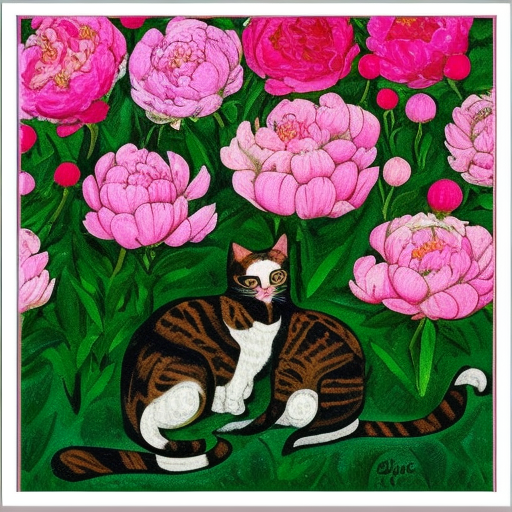

Image saved succesfully at: /aiffel/aiffel/workplace/EXPLORATION/Ex06/diffusers2/diffusion_img_2.png
Enter the prompt ("exit" to finish): the sea with sparkling surface in the dark


  0%|          | 0/25 [00:00<?, ?it/s]

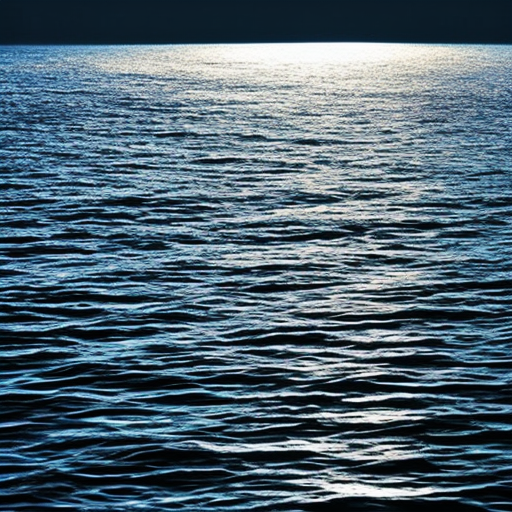

Image saved succesfully at: /aiffel/aiffel/workplace/EXPLORATION/Ex06/diffusers2/diffusion_img_3.png
Enter the prompt ("exit" to finish): exit
Exiting image generation.


In [5]:
generate_and_save_image(pipe, img_dir)

## 하이퍼파라미터를 조정해서 이미지 생성
- `height`, `width` : 생성될 이미지의 가로, 세로 픽셀 크기 조정
    - 8의 배수로 설정
- `num_inference_steps` : denosing 스텝수, 값이 커질수록 고해상도 이미지 생성
    - default=50
- `guidance_scale` : 주어진 프롬프트에 얼마나 근접한 이미지를 생성할지 설정하는 값
    - 값이 커질수록 근접한 이미지가 생성되지만, 이미지 품질이 떨어질수 있음
    - default=7.5


**위에서 만든 함수에 하이퍼파라미터 값을 받을수 있도록 수정**

In [6]:
# generate and save the images function
def diffusions(pipe, output_directory, base_filename='diffusion_img', 
                            num_inference_steps=25, 
                            guidance_scale=7.5, 
                            height=256, width=256):
    '''
    Generate an image using the provided prompt (taken as input),
    save it to the specified directory with a unique filename
    and allow adjusting hyperparameters
    
    Parameters:
        pipe : Image generation pipeline
        output_directory : The directory where the image will be saved
        base_filename : The base filename for the saved image (default : 'diffusion_img')
        num_inference_steps : The number of inference steps for image generation (default : 25)
        guidance_scale : Value determining how close the generate image will be to the given prompt (default:7.5)
        height, width : Height, width of the generated image in pixels (default : 256, must be a multiple of 8)
    '''
    while True:
        # take propt as input
        prompt = input('Enter the prompt ("exit" to finish): ')
        
        # check if prompt==exit
        if prompt.lower() == 'exit':
            print('Exiting image generation.')
            break
        
        # generate image with prompt
        image = pipe(prompt, 
                     num_inference_steps=num_inference_steps,
                     guidance_scale=guidance_scale,
                     height=height,
                     width=width).images[0]
        
        # make filename by appending a number
        filename = base_filename
        count = 1
        while os.path.exists(os.path.join(output_directory, f'{filename}_{count}.png')):
            count += 1
            
        # create the complete path for saving the image
        image_path = os.path.join(output_directory, f'{filename}_{count}.png')
        
        # save the imgae
        image.save(image_path)
        
        # display the image
        image.show()
        
        print(f'Image saved succesfully at: {image_path}')

In [8]:
diffusions(pipe, img_dir, num_inference_steps=50, height=752, width=1624) # for iphone wallpaper

Enter the prompt ("exit" to finish): Glittery pieces on a dreamy floral background


  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 6.78 GiB (GPU 0; 14.76 GiB total capacity; 9.36 GiB already allocated; 4.11 GiB free; 9.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

CUDA memory를 다썼다는 에러가 나온다
- 우진님이 공유해준 코드를 사용해본다

In [9]:
# check if CUDA(GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Device type: {device.type}')

# Check if it's a GPU
if device.type == "cuda":
    print("GPU is available.")
else:
    print("Running on CPU.")

# move the pipeline to the selecte device
pipe = pipe.to(device)

Device type: cuda
GPU is available.


In [10]:
diffusions(pipe, img_dir, num_inference_steps=50e, height=752, width=1624) # for iphone wallpaper

Enter the prompt ("exit" to finish): Glittery pieces on a dreamy space background


  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 6.78 GiB (GPU 0; 14.76 GiB total capacity; 9.52 GiB already allocated; 4.09 GiB free; 9.60 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

- 이미지사이즈때문일지 모르니 사이즈를 줄여본다

Enter the prompt ("exit" to finish): Glittery pieces on a dreamy space background


  0%|          | 0/50 [00:00<?, ?it/s]

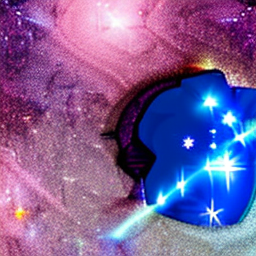

Image saved succesfully at: /aiffel/aiffel/workplace/EXPLORATION/Ex06/diffusers2/diffusion_img_4.png
Enter the prompt ("exit" to finish): cute black cats in the snowing beach


  0%|          | 0/50 [00:00<?, ?it/s]

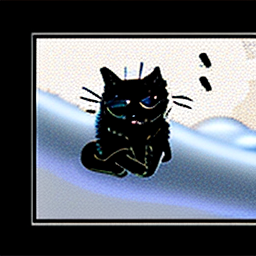

Image saved succesfully at: /aiffel/aiffel/workplace/EXPLORATION/Ex06/diffusers2/diffusion_img_5.png
Enter the prompt ("exit" to finish): cats in a field of peonies


  0%|          | 0/50 [00:00<?, ?it/s]

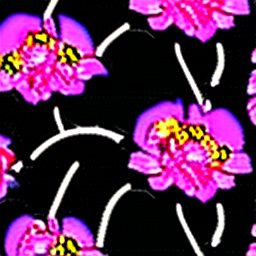

Image saved succesfully at: /aiffel/aiffel/workplace/EXPLORATION/Ex06/diffusers2/diffusion_img_6.png
Enter the prompt ("exit" to finish): exit
Exiting image generation.


In [11]:
diffusions(pipe, img_dir, num_inference_steps=50)

`num_inference_steps`가 25일때 이미지가 훨씬 예쁘다

# 여러개 이미지 생성하기
- 하나의 프롬프트로 여러개 이미지 생성

In [12]:
# 틀 만들기
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size  
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box = (i%cols * w, i // cols * h))
    return grid

In [13]:
# 이미지의 개수 
num_images = 6

# 프롬프트 입력
prompt = ['cats in a field of peonies'] * num_images

# 이미지 생성
images = pipe(prompt).images

# 이미지 출력
grid = image_grid(images, rows= 3, cols= 2)
grid

  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 1.88 GiB (GPU 0; 14.76 GiB total capacity; 11.64 GiB already allocated; 75.75 MiB free; 13.61 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [14]:
# clear gpu memory
torch.cuda.empty_cache()

In [15]:
# 이미지의 개수 
num_images = 6

# 프롬프트 입력
prompt = ['cats in a field of peonies'] * num_images

# 이미지 생성
images = pipe(prompt).images

# 이미지 출력
grid = image_grid(images, rows= 3, cols= 2)
grid

  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 1.88 GiB (GPU 0; 14.76 GiB total capacity; 11.84 GiB already allocated; 73.75 MiB free; 13.62 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

메모리를 지우는 코드를 실행했는데도 같은 에러가 발생한다

In [16]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Get the currently allocated GPU memory in bytes
    current_memory = torch.cuda.memory_allocated()
    
    # Get the peak GPU memory usage in bytes
    peak_memory = torch.cuda.max_memory_allocated()
    
    print(f"Current GPU memory usage: {current_memory / 1024**2:.2f} MB")
    print(f"Peak GPU memory usage: {peak_memory / 1024**2:.2f} MB")
else:
    print("CUDA not available. Running on CPU.")

Current GPU memory usage: 12129.21 MB
Peak GPU memory usage: 13805.83 MB


In [17]:
# Clear GPU memory
torch.cuda.empty_cache()

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Get the currently allocated GPU memory in bytes after clearing the cache
    current_memory = torch.cuda.memory_allocated()
    
    print(f"Current GPU memory usage after clearing cache: {current_memory / 1024**2:.2f} MB")
else:
    print("CUDA not available. Running on CPU.")

Current GPU memory usage after clearing cache: 12129.21 MB


- gpu 메모리 삭제가 되지않는다.
- 1) garbage collection을 이용해보고, 2) 메모리동기화를 해보고, 3) 안되면 커널 재시작한다

In [20]:
# 1. garbage collection
import gc

def check_gpu_memory():
    """
    Check GPU memory usage after clearing the cache (if GPU is available).
    """
    if torch.cuda.is_available():
        # Clear GPU memory cache
        torch.cuda.empty_cache()

        # Run Python's garbage collector
        gc.collect()
        
        # Synchronize the memory
        torch.cuda.synchronize()

        # Get the currently allocated GPU memory in bytes after clearing the cache
        current_memory = torch.cuda.memory_allocated()

        print(f"Current GPU memory usage after clearing cache: {current_memory / 1024**2:.2f} MB")
    else:
        print("CUDA not available. Running on CPU.")

In [21]:
check_gpu_memory()

Current GPU memory usage after clearing cache: 2477.85 MB


메모리가 점점 줄어든다...?

# Image-to-Image Generation
- 이미지를 입력으로 넣으면 다른 이미지로 변환

In [ ]:
# Image-to-Image Generation 파이프라인 불러오기    
from diffusers import StableDiffusionImg2ImgPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
)
pipe = pipe.to(device)

## 하나의 이미지 생성

In [ ]:
import requests  
from io import BytesIO

url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

# url 호출하기
response = requests.get(url)

# 이미지 열기
init_img = Image.open(BytesIO(response.content)).convert("RGB")  # 이미지를 메모리로 읽어와서 RGB로 변경합니다. 
init_img = init_img.resize((768, 512))  # 이미지의 크기를 조절합니다. 
init_img

In [ ]:
# # 클라우드에 이미지를 업로드해서 사용할 경우
# init_img = Image.open("/aiffel/aiffel/workplace/EXPLORATION/Ex06/diffusers/image.jpeg", mode = 'r')
# init_img = init_img.resize((768, 512)) 
# init_img

**하이퍼파라미터**

- `seed` : 동일한 입력 문장과 각종 설정을 넣었을때 동일한 시드 값을 주면 같은 이미지를 생성
- `strength` : 레퍼런스 이미지에서 얼마나 변형할지 설정하는 하이퍼파라미터
    - 값이 커질수록 원본 이미지와 다른 이미지를 생성
    - 0-1 사이 값 가능 (default = 0.8)
- `guidance_scale` : 얼마나 프롬프트에 근접한 이미지를 생성할지 결정
    - 값이 커질수록 문자열에 근접한 이미지를 생성하지만, 이미지 품질은 떨어짐
    - default = 7.5
- `num_inference_steps` : denosing 스텝수
    - 값이 커질수록 고해상도 이미지가 출력되지만 출력되는 시간은 오래걸림


In [ ]:
generator = torch.Generator(device=device).manual_seed(1024)   # 모델을 사용할 때마다 동일한 이미지를 생성하기 위해 seed를 설정합니다.  

images = pipe(prompt=prompt, image=init_img, strength=0.75, guidance_scale=7.5).images
images[0].save("/aiffel/aiffel/workplace/EXPLORATION/Ex06/diffusers/fantasy_landscape2.png")
images[0]

## 여러개 이미지 생성

In [ ]:
num_images = 2

# 프롬프트 입력
prompt = ['A landscape full of glitter dust'] * num_images

# 이미지 생성
generator = torch.Generator(device=device).manual_seed(1024)
images = pipe(prompt=prompt, image=init_img, strength=0.9, guidance_scale=13.5, num_inference_steps=50, generator=generator).images
images

# 이미지 출력
grid = image_grid(images, rows=1, cols=2)
grid